### 청와대 국민청원 데이터에서 각 분류별 Top1 추출

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")
import datetime as dt
### 세종사전 실행
from konlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
twitter = Twitter()

In [2]:
df = pd.read_excel("test/test_가짜.xlsx")
df
# df.Date = pd.to_datetime(df.Date)

,Date,Title
0,2020-05-20,"[오늘 이 뉴스] ""25개월 딸 성폭행""은 가짜 청원"
1,2020-05-20,[e글중심] 53만 국민청원 반전 “청와대 청원이 희망인 사람도 있는데”
2,2020-05-20,"씨름 꿈나무 출신 31세 최신종, 나흘간격으로 여성 2명 살해"
3,2020-05-20,"20만명 넘게 동의한 靑 허위 오인 청원, 벌써 세 번째"
4,2020-05-20,[모닝브리핑] 오늘 고3 등교 설렘반 걱정반
...,...,...
8177,2020-02-18,연간 억원에 이르는 국민 혈세로 운영되는 한국과학창의재단...
8178,2020-02-18,정선생 상식과 몰상식의 투쟁 역사 국민이 원하는건 청와대 국민청원
8179,2020-02-18,국민 청원 국민 청원
8180,2020-02-18,국민청원


## 키워드 변경 함수

In [3]:
def rep_keyword(before, after):
    ind = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].index
    df.iloc[ind,1] = df.loc[df['Title'].str.contains(before)].loc[:,"Title"].str.replace(before,after,case = False)

In [4]:
rep_keyword("n번방","엔번방")
rep_keyword("N번방","엔번방")

In [5]:
from string import punctuation
df2 = list(df.Title)

In [6]:
def strip_punc(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for sent in df2:
    clean_df = strip_punc(sent)
    clean_title.append(clean_df)

clean_title[0:3]

['오늘 이 뉴스 25개월 딸 성폭행은 가짜 청원',
 'e글중심 53만 국민청원 반전  “청와대 청원이 희망인 사람도 있는데”',
 '씨름 꿈나무 출신 31세 최신종 나흘간격으로 여성 2명 살해']

In [7]:
from konlpy.tag import Kkma
kkma = Kkma()
import re
import time
import datetime
start = time.time()

dataset = []
for i in range(len(clean_title)):
    dataset.append(kkma.nouns(re.sub('[^가-힣a-zA-Z\s]','',clean_title[i])))
    
sec = time.time() - start
times = str(datetime.timedelta(seconds = sec)).split(".")
times = times[0]
print(times)

0:03:31


In [8]:
from gensim import corpora, models
import gensim

In [9]:
high_score_reviews = dataset

In [10]:
high_score_reviews = [[y for y in x if not len(y)==1]
                     for x in high_score_reviews]
diction = corpora.Dictionary(high_score_reviews)
corpus = [diction.doc2bow(text) for text in high_score_reviews]


In [11]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

coherence_values = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    coherence_model_lda = CoherenceModel(model = ldamodel, texts = high_score_reviews, dictionary = diction,
                                        topn = 10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


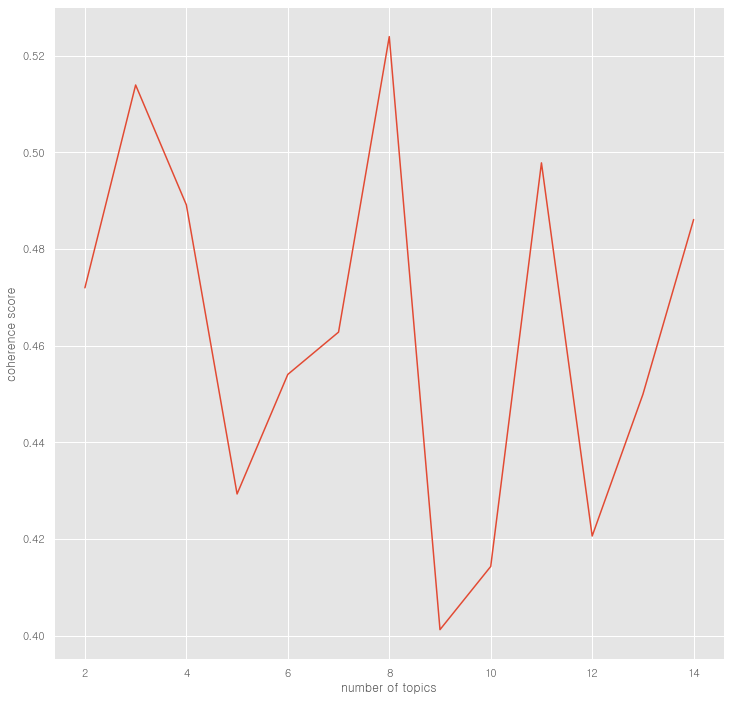

In [12]:
x = range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [13]:
import matplotlib.pyplot as plt
perplexity_values = []
for i in range(2, 20):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= i, id2word= diction)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

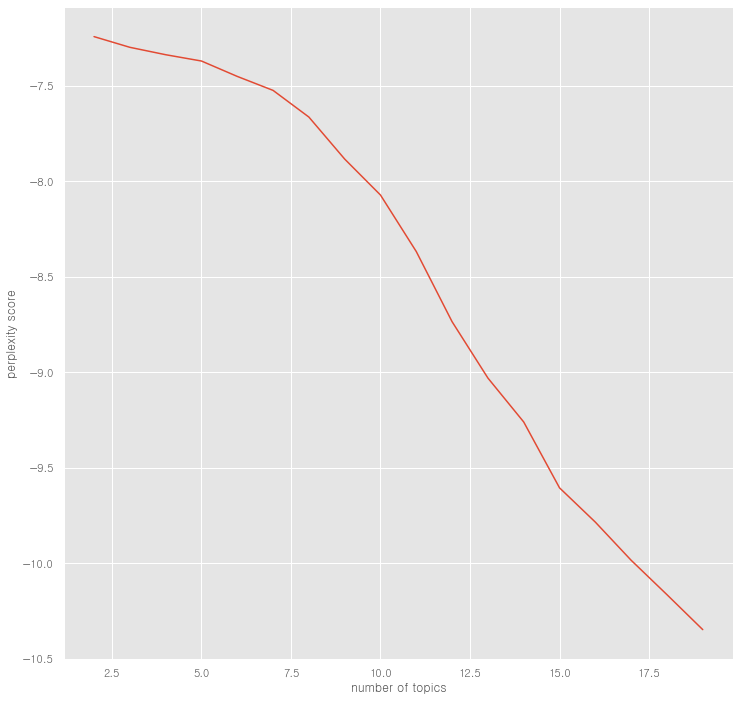

In [14]:
x = range(2,20)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [15]:
## 토픽 개수 7개 아니면 11개가 적당할거 같다.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics= 11, alpha = 0.1, id2word= diction)

In [16]:
ldamodel.print_topics(num_words = 20)

[(0,
  '0.050*"청원" + 0.049*"국민" + 0.047*"국민청원" + 0.039*"대구" + 0.034*"사망" + 0.034*"신천지" + 0.022*"누리" + 0.021*"번째" + 0.020*"경북" + 0.019*"그램" + 0.019*"텔레그램" + 0.018*"교회" + 0.017*"천명" + 0.014*"청와대" + 0.011*"탄핵" + 0.010*"주민" + 0.010*"조치" + 0.010*"지옥" + 0.010*"미국" + 0.010*"문재"'),
 (1,
  '0.052*"미투" + 0.044*"연대" + 0.022*"배우" + 0.020*"부탁" + 0.020*"사건" + 0.018*"찬성" + 0.017*"국민" + 0.017*"청원" + 0.016*"만원" + 0.016*"자살" + 0.015*"이동" + 0.015*"단역" + 0.015*"단역배우" + 0.015*"자살사건" + 0.015*"국민청원" + 0.015*"이재" + 0.014*"개정" + 0.012*"관심" + 0.012*"튜브" + 0.012*"유튜브"'),
 (2,
  '0.135*"국민" + 0.134*"청원" + 0.129*"국민청원" + 0.047*"신천지" + 0.044*"청와대" + 0.017*"해체" + 0.012*"의혹" + 0.011*"강제" + 0.010*"코로나" + 0.009*"교주" + 0.007*"수사" + 0.007*"주세" + 0.007*"진자" + 0.005*"이만희" + 0.005*"노력" + 0.005*"뉴스" + 0.005*"촉구" + 0.005*"처벌" + 0.005*"검찰" + 0.004*"해산"'),
 (3,
  '0.035*"네이버" + 0.033*"단체" + 0.031*"청원" + 0.030*"출처" + 0.026*"국민" + 0.024*"뉴스" + 0.024*"엑소" + 0.024*"환자" + 0.024*"국민청원" + 0.022*"일보" + 0.019*"이스" + 0.019*"트와이스" + 0.019

In [17]:
import pyLDAvis

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float

In [18]:
from gensim.models import LdaModel # To use the LDA model

import pyLDAvis.gensim # To visualise LDA model effectively

import pandas as pd


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, diction)
vis

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.101792 -0.032710       1        1  18.446245
4     -0.152154  0.216130       2        1  16.164341
2     -0.109616 -0.094620       3        1  12.905080
6     -0.072956 -0.028865       4        1  12.398438
8     -0.138414 -0.015808       5        1  10.380862
5     -0.018073 -0.083803       6        1   8.899256
10     0.044981 -0.061475       7        1   5.254180
0      0.016742 -0.000969       8        1   5.092783
3      0.157799  0.088782       9        1   3.792021
1      0.232938  0.002949      10        1   3.522908
9      0.140543  0.010388      11        1   3.143886, topic_info=      Term         Freq        Total Category  logprob  loglift
166     재인  1747.000000  1747.000000  Default  30.0000  30.0000
450    문재인  1592.000000  1592.000000  Default  29.0000  29.0000
556    대통령  1617.000000  1617.000000  Default  28.0000  28.0000
3984    대구   921.000000   921.000000  Default  27.0000  27.0000
3180   중국인   736.000000   736.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
5       청원   140.218971  9349.531601  Topic11  -3.2686  -0.7402
7     국민청원   117.968163  8573.180212  Topic11  -3.4414  -0.8263
308     나라    20.824899   239.668282  Topic11  -5.1756   1.0166
781     방탄    16.177622    89.977027  Topic11  -5.4281   1.7438
12     청와대    21.872308  2413.813841  Topic11  -5.1266  -1.2440

[614 rows x 6 columns], token_table=      Topic      Freq Term
term                      
5219      4  0.932679   가입
5219     10  0.043719   가입
112       1  0.807682  가해자
112       2  0.008974  가해자
112       3  0.017948  가해자
...     ...       ...  ...
2389      4  0.871404   회의
2389      6  0.117054   회의
4382      7  0.855041   회장
951       3  0.934407   효과
951       5  0.022790   효과

[1536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 7, 9, 6, 11, 1, 4, 2, 10])

In [19]:
kk = ldamodel.show_topic(1,topn = 80000)
type(ldamodel.show_topic)
kk2 = pd.DataFrame(kk)
kk2
#kk2.to_csv("test0911_1.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1
0,미투,0.051543
1,연대,0.044437
2,배우,0.021806
3,부탁,0.020439
4,사건,0.020146
...,...,...
11875,합동강간,0.000029
11876,호기심,0.000029
11877,성폭력사건,0.000029
11878,한복판,0.000029


In [20]:
def make_topictable_per_doc(ldamodel,corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key = lambda x: (x[1]), reverse = True)
        
        
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num),round(prop_topic,4),topic_list]),
                                                ignore_index= True)
            else:
                break
                    
    return(topic_table)

                

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
topictable = make_topictable_per_doc(ldamodel,corpus)
topictable = topictable.reset_index()
topictable.columns = ["문서 번호", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]
topictable["문서 내용"] = df.Title
topictable = topictable.loc[:,["문서 번호", "문서 내용", "가장 비중이 높은 토픽", "가장 높은 토픽의 비중", "각 토픽의 비중"]]
topictable[:10]

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,문서 내용,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,"[오늘 이 뉴스] ""25개월 딸 성폭행""은 가짜 청원",10.0,0.6071,"[(0, 0.014086812), (1, 0.014087597), (2, 0.014..."
1,1,[e글중심] 53만 국민청원 반전 “청와대 청원이 희망인 사람도 있는데”,8.0,0.8992,"[(0, 0.0100839995), (1, 0.010083181), (2, 0.01..."
2,2,"씨름 꿈나무 출신 31세 최신종, 나흘간격으로 여성 2명 살해",3.0,0.9086,"[(3, 0.9086054)]"
3,3,"20만명 넘게 동의한 靑 허위 오인 청원, 벌써 세 번째",7.0,0.6527,"[(0, 0.21641265), (1, 0.014540002), (2, 0.0145..."
4,4,[모닝브리핑] 오늘 고3 등교 설렘반 걱정반,2.0,0.4249,"[(0, 0.21625291), (1, 0.014001761), (2, 0.4248..."
5,5,“25개월 딸 성폭행” 허위 국민청원 게시자 입건,6.0,0.9009,"[(6, 0.9009454)]"
6,6,"""25개월 딸 성폭행 당했다"" 53만 분노한 청원의 진실",9.0,0.5554,"[(0, 0.016402155), (1, 0.016402775), (2, 0.296..."
7,7,靑청원 '초등생이 25개월 딸 성폭행'에 53만명 속았다,6.0,0.8758,"[(0, 0.012418808), (1, 0.012417331), (2, 0.012..."
8,8,‘25개월 딸 성폭행’ 靑청원은 엄마의 거짓말,9.0,0.5733,"[(0, 0.016401365), (1, 0.016401732), (2, 0.016..."
9,9,"""25개월 딸 성폭행 당해"" 허위 청원 경찰, 불구속 입건",6.0,0.8764,"[(0, 0.012360769), (1, 0.012360828), (2, 0.012..."


In [22]:
# topictable.to_csv("test0911_2.csv",encoding = "cp949", index = False)

C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
